In [141]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [143]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct

aux.shape, targets.shape, run_path

((1160, 5),
 (1160, 30),
 '/media/beans/ssd/blender_membank/dataloader_10/run_19')

In [144]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

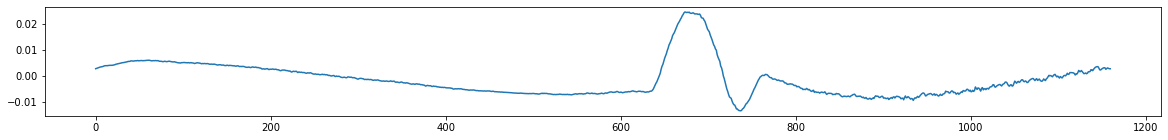

In [145]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

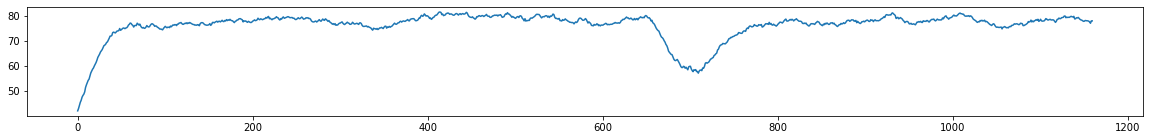

In [146]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [147]:
ccs = []
for i in range(len(targets)):
    traj = targets[i]
    s = kph_to_mps(speeds[i])
    ccs.append(get_curve_constrained_speed(traj, s))

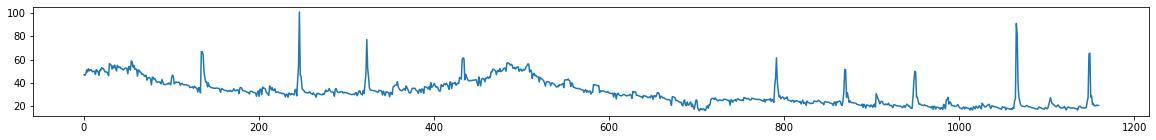

In [148]:
# curve constrained speeds
plt.figure(figsize=(20,2))
plt.plot(ccs)

In [94]:
speeds.max()

54.991234

<BarContainer object of 10 artists>

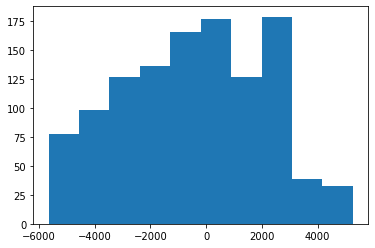

In [95]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

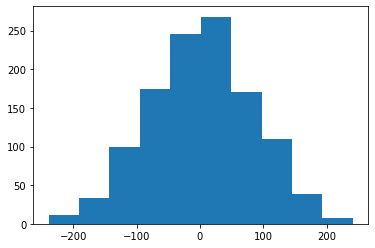

In [96]:
plt.hist(torque[1:]-torque[:-1])[2]

In [97]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [98]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [99]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)
imgs.shape, aux.shape

run_id = "sim"
model_stem = "7.5_avg"
make_vid(run_id, model_stem, imgs, aux, targets=targets)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [72]:
curve_prep_slowdown_time_sec = 3
headings = []
for i in range(len(targets)):
    traj, speed_mps = targets[i], kph_to_mps(aux[i, 2])
    future_heading = get_heading_at_dist_along_traj(traj, speed_mps*curve_prep_slowdown_time_sec)
    headings.append(future_heading)

/media/beans/ssd/bespoke/traj_utils.py:112: RuntimeWarning: invalid value encountered in arcsin
  heading = np.arcsin((next_wp_x - this_wp_x)/(next_wp_y - this_wp_y))


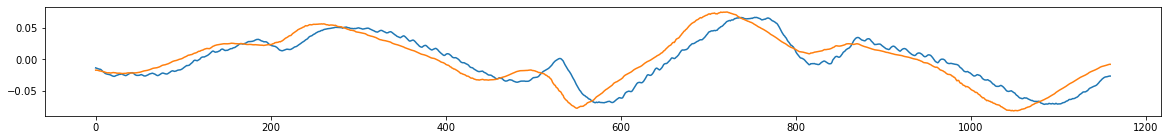

In [73]:
plt.figure(figsize=(20,2))
plt.plot(wp_angles)
plt.plot(np.array(headings)/8)

In [81]:
curve_prep_slowdown_time_sec = 4
angles = []
for i in range(len(targets)):
    traj, speed_mps = targets[i], kph_to_mps(aux[i, 2])
    angle, _, _ = angle_to_wp_from_dist_along_traj(traj, speed_mps*curve_prep_slowdown_time_sec)
    angles.append(angle)

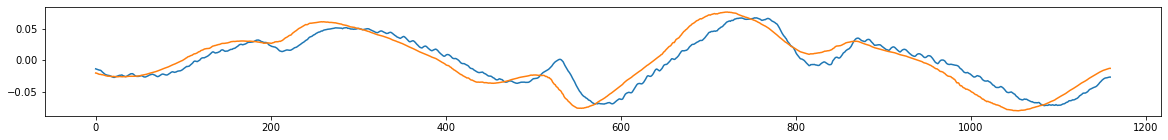

In [82]:
plt.figure(figsize=(20,2))
plt.plot(wp_angles)
plt.plot(np.array(angles)/4.5) # 3, 3.5; 4, 4.5; 

((1160, 100, 640, 3), (1160, 5))

In [178]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 8.902309, 12.186928, 12.699043,  9.915404, 10.052788,  8.741862,
        9.250651,  9.645082, 12.089131, 11.711972,  8.240655, 10.827622],
      dtype=float32)

In [191]:
all_aux = []
all_targets = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        all_aux.append(aux)
        all_targets.append(targets)
        
all_aux = np.stack(all_aux, axis=0)
all_targets = np.stack(all_targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [192]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_targets[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

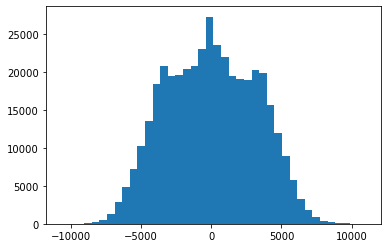

In [193]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

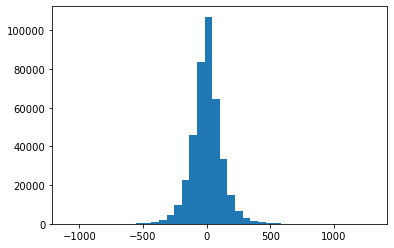

In [194]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [195]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(553.3167452863082, 8499.282779233255)

In [196]:
all_targets.shape

(348, 1160, 30)

In [197]:
mean_angles = abs(all_targets).mean(axis=0).mean(0)
mean_angles

array([0.016161  , 0.01778082, 0.01953145, 0.02135348, 0.0232172 ,
       0.02510438, 0.0270045 , 0.02891101, 0.03081757, 0.03271662,
       0.03459845, 0.03646011, 0.0383039 , 0.04013129, 0.04194269,
       0.04374716, 0.04555019, 0.04734891, 0.04914264, 0.05093082,
       0.06850024, 0.08525577, 0.10095005, 0.11566653, 0.12940976,
       0.14213718, 0.15388523, 0.16471924, 0.17469458, 0.18377657],
      dtype=float32)

In [198]:
mean_angles[-1] / mean_angles[0]

11.371612

In [206]:
mean_angles[-1] / mean_angles[0]

11.371612

In [210]:
mean_angles[0] / .015

1.0773997753858566

<BarContainer object of 40 artists>

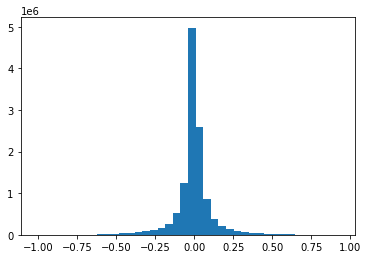

In [203]:
plt.hist(all_targets.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

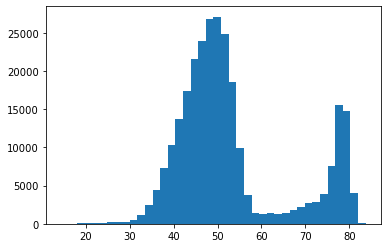

In [189]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

In [190]:
all_targets.min(), all_targets.max()

(-0.7614489, 0.6916083)

In [ ]:
from scipy.signal import convolve2d
def smooth_targets(targets, window_size=4):
    # expects 3 dims, last is just padded
    smoothed = convolve2d(targets[:, :, 0], np.ones((1, window_size)), 'same') / window_size
    smoothed = np.expand_dims(smoothed, -1)
    return smoothed